# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
use_cuda = torch.cuda.is_available()
device =torch.device('cuda' if use_cuda else 'cpu')
print(f"The device is: {device}")

The device is: cuda


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform =transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                              transforms.RandomVerticalFlip()])

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10(root="/kaggle/working",train =True, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size =32, shuffle =True, num_workers =2)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10(root="/kaggle/working",train =False, transform = transform, download=True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle =True, num_workers =2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /kaggle/working/cifar-10-python.tar.gz to /kaggle/working
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## Exploring the data
print(f"Training set has: {train_data.__len__()} samples")
print(f"Test set has: {test_data.__len__()} samples")


Training set has: 50000 samples
Test set has: 10000 samples


In [7]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    print(f"Image shape : {np.shape(images[0].numpy())} \n")
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Image shape : (3, 32, 32) 

horse


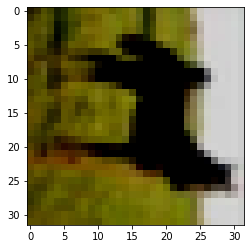

deer


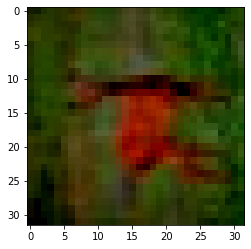

truck


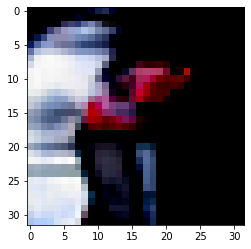

horse


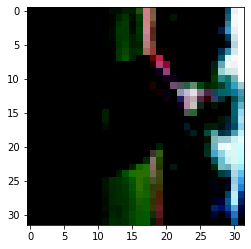

ship


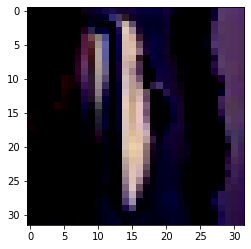

In [8]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [22]:
class mynet(nn.Module):
    def __init__(self):
        super(mynet, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, 3)       
        self.conv2 = nn.Conv2d(128, 256, 4)
        self.conv3 = nn.Conv2d(256, 512, 3)

        self.fc1 = nn.Linear(512 * 2 * 2, 200)
        self.bn1=nn.BatchNorm1d(200)

        self.fc2= nn.Linear(200,90)
        self.bn2=nn.BatchNorm1d(90)

        self.fc3 = nn.Linear(90, 50)
        self.bn3=nn.BatchNorm1d(50)

        self.fc4 = nn.Linear(50, 10)
        
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):

        #conv layer 1
        x=self.conv1(x)
        x=F.relu(x)
        x=self.pool(x)

        #conv layer 2
        x=self.conv2(x)
        x=F.relu(x)
        x=self.pool(x)

        #conv layer 3
        x=self.conv3(x)
        x=F.relu(x)
        x=self.pool(x)

        #flatten
        x=x.reshape(-1, 2*2*512)

        #fc 1
        x=self.fc1(x)
        x=F.relu(x)

        x=self.bn1(x)

        #fc2
        x=self.fc2(x)
        x=F.relu(x)
        x = self.dropout(x)
        x=self.bn2(x)

        #fc3
        x=self.fc3(x)
        x=F.elu(x)

        x=self.bn3(x)

        #fc4
        x=self.fc4(x)
        x=F.softmax(x,dim=1)       
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [30]:
model = mynet().to(device)

In [31]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer =optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [32]:
def get_accuracy(pred, labels):
    total = 0
    correct = 0 
    labels , pred = labels.cpu() , pred.cpu()
    _,predicted = torch.max(pred , 1)
    total += len(labels.numpy())
    
    correct += ((predicted == labels).numpy()).sum()
    return correct/total
    
    
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

In [33]:
epochs =[]
loss=[]
acc=[]
for epoch in range(20):
    train_loss,train_acc, model = train_one_epoch(model, train_loader,
                                        optimizer, loss_function)
    message = (f"epoch:{epoch+1}   Training loss:{train_loss:.2f}   "
               f"Training Accuracy:{100*train_acc:.2f} %")
    print(message)
    epochs.append(epoch)
    loss.append(train_loss)
    acc.append(train_acc)

epoch:1   Training loss:2.15   Training Accuracy:30.85 %
epoch:2   Training loss:2.08   Training Accuracy:37.02 %
epoch:3   Training loss:2.04   Training Accuracy:41.68 %
epoch:4   Training loss:2.01   Training Accuracy:44.37 %
epoch:5   Training loss:2.00   Training Accuracy:45.69 %
epoch:6   Training loss:1.97   Training Accuracy:49.00 %
epoch:7   Training loss:1.95   Training Accuracy:50.76 %
epoch:8   Training loss:1.94   Training Accuracy:51.77 %
epoch:9   Training loss:1.93   Training Accuracy:52.89 %
epoch:10   Training loss:1.91   Training Accuracy:54.56 %
epoch:11   Training loss:1.90   Training Accuracy:55.58 %
epoch:12   Training loss:1.92   Training Accuracy:54.00 %
epoch:13   Training loss:1.91   Training Accuracy:54.49 %
epoch:14   Training loss:1.95   Training Accuracy:50.78 %
epoch:15   Training loss:1.89   Training Accuracy:56.88 %
epoch:16   Training loss:1.88   Training Accuracy:57.79 %
epoch:17   Training loss:1.87   Training Accuracy:59.09 %
epoch:18   Training los

Plots

Text(0.5, 1.0, 'Train accuracy v/s epochs')

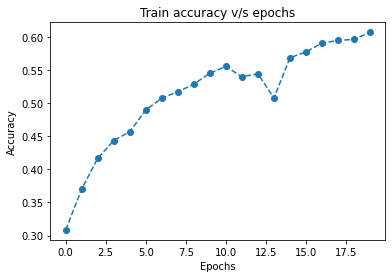

In [34]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,acc, 'o--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train accuracy v/s epochs")

Text(0.5, 1.0, 'Train loss v/s epochs')

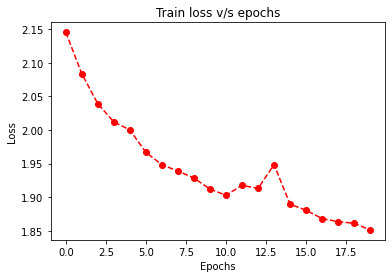

In [35]:
## Plotting Training accuracy against the epochs
plt.plot(epochs,loss, 'ro--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train loss v/s epochs")

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [36]:
## YOUR CODE HERE ##
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels =images.to(device), labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data , 1)
        total += labels.size(0)
        correct += ((predicted.cpu() == labels.cpu()).numpy()).sum()
print(f"accuracy of the network on test set:{100*correct/total}%")
        

accuracy of the network on test set:62.26%


## Saving your model
Using `torch.save`, save your model for future loading.

In [37]:
torch.save(model,"./mynet.pth")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

The accuracy of my network in making predicitons on test set is about 62%. Compared to the above mentioned models, the accuracy of my network is relatively low. So I have 2 recommendations here. First one is, provided the project is allocated with ample time to fine-tune the network for further improvements building the network would make sense, as there might be possibility that network might perform as good as above mentioned models. Second recommendation would be, if the project has very tight dealine buying would be an option.



**Double click this cell to modify it**